In [3]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm_notebook as tqdm

from mbptycho.code.simulation import reloadSimulation
from skimage.feature import register_translation
from scipy import io
from mbptycho.code.reconstruction import ReconstructionT

gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
probe_2d = io.loadmat('/raid/home/skandel/code/mbptycho/experiments/matlab/datasets/recon_probe_29902.mat')["prb"]
probes_3d_path = '/raid/home/skandel/code/mbptycho/experiments/matlab/datasets/probe_02.mat'

In [6]:
probe_rescaled = probe_2d / np.abs(probe_2d).max()
probe_trimmed = probe_rescaled.copy()
probe_2d[np.abs(probe_trimmed) < 0.02] = 0
np.sum(np.abs(probe_2d)**2), np.max(np.abs(probe_2d)**2)

(10405784.458692044, 523435.2684263936)

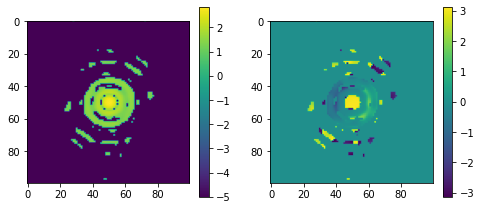

In [7]:
plt.figure(figsize=[8,3.5])
plt.subplot(121)
plt.imshow(np.log10(np.abs(probe_2d) + 1e-5))
plt.colorbar()
plt.subplot(122)
plt.imshow(np.angle(probe_2d))
plt.colorbar()
plt.show()

In [8]:
strain_type = 'point_inclusion'
data_path =  f'/raid/home/skandel/code/mbptycho/experiments/python/{strain_type}/'
sim_data_path = f'{data_path}/sim_{strain_type}.pkl'
sample_data_path = f'{data_path}/sample_{strain_type}.pkl'

save_plots = False

In [9]:
sm = reloadSimulation(sim_data_path, reload_sim=True, 
                      reload_sample_only_filename=sample_data_path,
                      new_sim_params={'poisson_noise':True, 
                                      'probes_matlab_file':probes_3d_path},
                      new_extra_sample_params={'strain_type':strain_type})#sim_params={"HKL_list":[[1, 2, 0]]}
sm.sample.Ux_trunc.shape, sm.sample.params.sample_pix_size

File exists. Reloading...


((200, 200, 22), 0.005476704545454546)

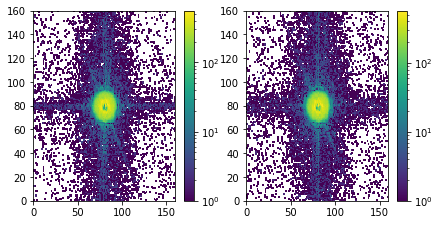

46304
[(703, 187969), (458, 103902), (1330, 210124)]
(121, 160, 160)


In [24]:
fig = plt.figure(figsize=[7,3.5])
plt.subplot(1,2,1)

data_out = np.fft.fftshift(sm.simulations_per_peak[0].diffraction_patterns[0])
data_out[data_out < 1.] = 0
plt.pcolormesh(data_out,
               norm=mpl.colors.LogNorm())
plt.colorbar()
plt.subplot(1,2,2)

data_out = np.fft.fftshift(sm.simulations_per_peak[0].diffraction_patterns[15])
data_out[data_out < 1.] = 0
plt.pcolormesh(data_out,
               norm=mpl.colors.LogNorm())
plt.colorbar()
plt.show()
print(np.abs(sm.simulations_per_peak[0].diffraction_patterns[0] - 
             sm.simulations_per_peak[0].diffraction_patterns[50]).sum())

print([(sm.simulations_per_peak[i].diffraction_patterns.max(),
        sm.simulations_per_peak[i].diffraction_patterns.sum(axis=(1,2)).max())
       for i in range(3)])
print(sm.simulations_per_peak[0].diffraction_patterns.shape)

In [25]:
cmap = mpl.cm.get_cmap('coolwarm')
cmap.set_bad('black')

<ipython-input-25-05d9d71900bf>:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
  cmap.set_bad('black')


In [26]:
ux = sm.sample.Ux_trunc #/ sm.sample.params.lattice[1]
uy = sm.sample.Uy_trunc #/ sm.sample.params.lattice[1]
uz = sm.sample.Uz_trunc #/ sm.sample.params.lattice[1]
dux = np.gradient(ux)#, sm.sample.params.sample_pix_size)
duy = np.gradient(uy)#, sm.sample.params.sample_pix_size)
duz = np.gradient(uz)#, sm.sample.params.sample_pix_size)
du = np.stack([dux, duy, duz], axis=0)

In [27]:
plots_3d_mask_trunc = (~sm.sample.obj_mask_trunc) | (~sm.sample.amplitudes_trunc_mask)

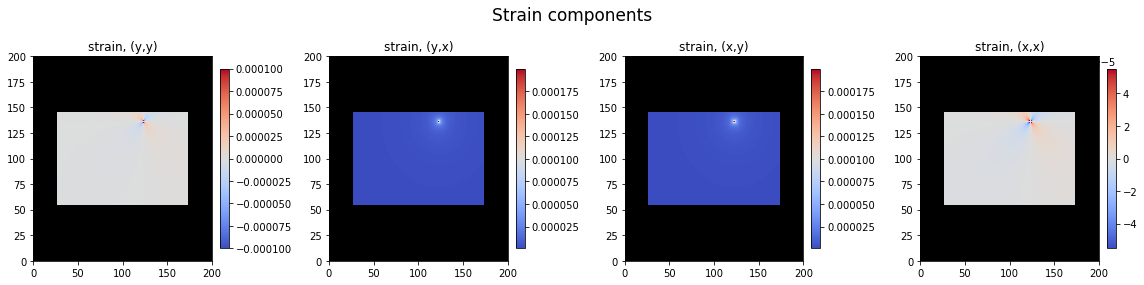

In [28]:
s = np.zeros(du.shape)
fig, axs = plt.subplots(1,4, figsize=(16,4))
coord_axes = {0:'y', 1:'x', 2:'z'}
for i in range(2):
    for j in range(2):
        s[i,j] = 0.5 * (du[j,i] + du[i,j])
        s[i,j][plots_3d_mask_trunc] = np.nan
        #s[i,j][~sm.sample.amplitudes_trunc_mask] = np.nan
        if i < 2 and j < 2:
            sl = s[i,j, :, :, 10]
            
        elif i < 2 and j ==2 :
            sl = s[i, j, :,:,10]
        else:
            sl = s[i, j, :, :,10]
        
        im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap)
        axs[i * 2 + j].set_title(f'strain, ({coord_axes[i]},{coord_axes[j]})')
        plt.colorbar(im, ax=axs[2*i + j], fraction=0.046, pad=0.04)
plt.suptitle('Strain components', fontsize=17)
plt.tight_layout()

if save_plots:
    plt.savefig(f'{data_path}strain.pdf', bbox_inches='tight')
          
plt.show()  

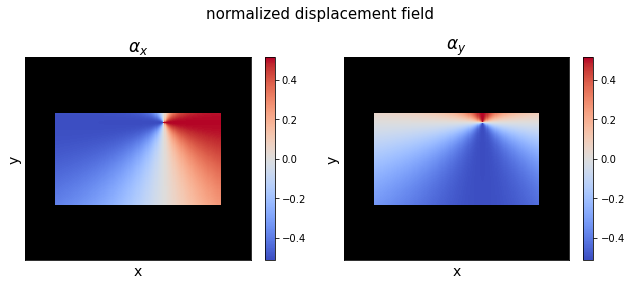

In [29]:
plt.figure(figsize=[9,4])

plt.subplot(1,2,1)
front = sm.sample.Ux_trunc / sm.sample.params.lattice[1]
front[plots_3d_mask_trunc] = np.nan
cmap = mpl.cm.get_cmap('coolwarm')
#cmap.set_bad('black')
plt.pcolormesh(front[...,11], cmap=cmap)
plt.colorbar()
#cbar = plt.colorbar(ticks=[-2, -1, 0, 1, 2])
#cbar.ax.tick_params(labelsize=14)
#cbar.ax.set_ylabel(r'$\alpha_y$', fontsize=17) 
plt.xticks([])
plt.yticks([])
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title(r'$\alpha_x$', fontsize=17)

plt.subplot(1,2,2)
front = sm.sample.Uy_trunc / sm.sample.params.lattice[1]
front[plots_3d_mask_trunc] = np.nan
cmap = mpl.cm.get_cmap('coolwarm')
#cmap.set_bad('black')
plt.pcolormesh(front[...,11], cmap=cmap)
plt.colorbar()
#cbar = plt.colorbar(ticks=[-0.2, -0.1, 0, 0.1, 0.2])
#cbar.ax.tick_params(labelsize=14)
#cbar.ax.set_ylabel(r'$\alpha_y$', fontsize=17) 
plt.xticks([])
plt.yticks([])
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title(r'$\alpha_y$', fontsize=17)
plt.suptitle("normalized displacement field", fontsize=15)
plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}displacement.pdf', bbox_inches='tight')
plt.show()

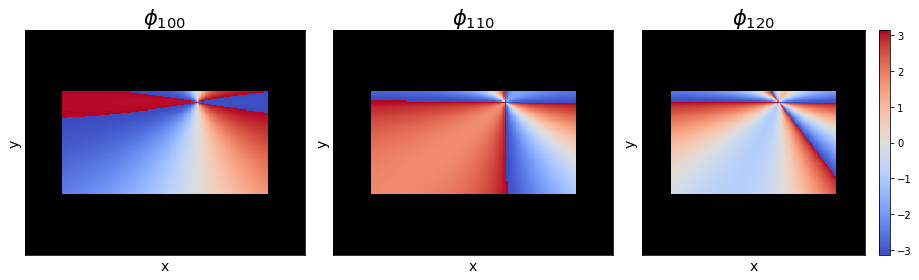

In [30]:
plt.figure(figsize=[13,4])
plt.subplot(1,3,1)
front = np.angle(sm.sample.rhos[0])
front[plots_3d_mask_trunc] = np.nan
plt.pcolormesh(front[...,11], cmap='coolwarm', vmin=-np.pi, vmax=np.pi)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title(r"$\phi_{100}$", fontsize=21)
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,2)
front = np.angle(sm.sample.rhos[1])
front[plots_3d_mask_trunc] = np.nan
plt.pcolormesh(front[...,11], cmap='coolwarm', vmin=-np.pi, vmax=np.pi)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title(r"$\phi_{110}$", fontsize=21)
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,3)
front = np.angle(sm.sample.rhos[2])
front[plots_3d_mask_trunc] = np.nan
plt.pcolormesh(front[...,11], cmap='coolwarm', vmin=-np.pi, vmax=np.pi)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title(r"$\phi_{120}$", fontsize=21)
plt.colorbar()
plt.xticks([])
plt.yticks([])

plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}phases.pdf', bbox_inches='tight')
plt.show()

0.2817488748598918 0.0
0.17479566331246596 0.0
0.36452527048646927 0.0


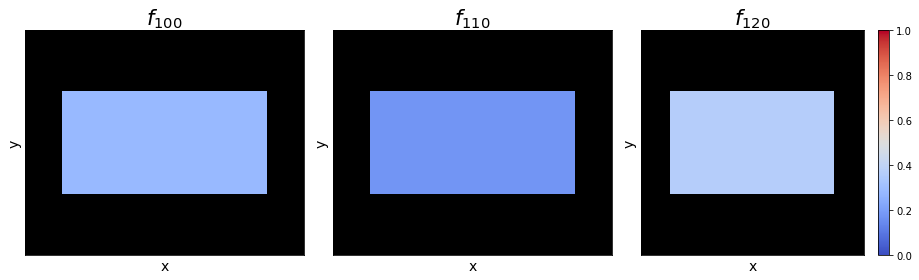

In [31]:
plt.figure(figsize=[13,4])
plt.subplot(1,3,1)

front = np.abs(sm.sample.rhos[0])
print(front.max(), front.min())
front[plots_3d_mask_trunc] = np.nan

plt.pcolormesh(front[...,11], cmap='coolwarm', vmin=0, vmax=1.0)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title(r"$f_{100}$", fontsize=21)
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,2)
front = np.abs(sm.sample.rhos[1])
print(front.max(), front.min())
front[plots_3d_mask_trunc] = np.nan
plt.pcolormesh(front[...,11], cmap='coolwarm', vmin=0, vmax=1.0)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title(r"$f_{110}$", fontsize=21)
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,3)
front = np.abs(sm.sample.rhos[2])
print(front.max(), front.min())
front[plots_3d_mask_trunc] = np.nan
plt.pcolormesh(front[...,11], cmap='coolwarm', vmin=0, vmax=1.0)

plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title(r"$f_{120}$", fontsize=21)
plt.colorbar()
plt.xticks([])
plt.yticks([])

plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}amplitudes.pdf', bbox_inches='tight')
plt.show()

# Reconstrucion

In [32]:
recons = ReconstructionT(simulation=sm, reconstruct_phases_only=True)

In [33]:
if recons.reconstruct_phases_only:
    recons.setPhaseAdamOptimizer(1e-1)
else:
    recons.setDisplacementAdamOptimizer(5e-2)
recons.setAmplitudeAdamOptimizer(1e-2)

In [55]:
recons.minimizeAndCheckErrors(100, 5)

Iter 405 floss   11 err_rho 0.198 0.151 0.12 
Iter 410 floss 10.1 err_rho 0.198 0.151 0.119 
Iter 415 floss 10.6 err_rho 0.197 0.15 0.118 
Iter 420 floss 10.4 err_rho 0.197 0.15 0.117 
Iter 425 floss   10 err_rho 0.196 0.149 0.117 
Iter 430 floss   11 err_rho 0.196 0.149 0.116 
Iter 435 floss   10 err_rho 0.196 0.149 0.116 
Iter 440 floss 10.1 err_rho 0.196 0.149 0.115 
Iter 445 floss 10.2 err_rho 0.196 0.149 0.115 
Iter 450 floss 9.03 err_rho 0.196 0.149 0.115 
Iter 455 floss 10.4 err_rho 0.195 0.148 0.114 
Iter 460 floss 10.6 err_rho 0.195 0.148 0.114 
Iter 465 floss 11.5 err_rho 0.195 0.148 0.114 
Iter 470 floss 9.09 err_rho 0.195 0.148 0.114 
Iter 475 floss 9.99 err_rho 0.195 0.148 0.114 
Iter 480 floss 9.14 err_rho 0.195 0.148 0.114 
Iter 485 floss 9.35 err_rho 0.195 0.148 0.114 
Iter 490 floss 9.62 err_rho 0.196 0.148 0.114 
Iter 495 floss 9.89 err_rho 0.196 0.148 0.113 
Iter 500 floss 9.71 err_rho 0.196 0.148 0.113 


In [56]:
if not recons.reconstruct_phases_only:
    amplitudes_2d_all, ux_out, uy_out, rho_out = recons.getNumpyOutputs()
else:
    amplitudes_2d_all, rho_out = recons.getNumpyOutputs()

In [57]:

true_items = {}
recons_items = {}

if not recons.reconstruct_phases_only:
    
    recons_items[r"$\alpha_x$"] = (ux_out  - ux_out.mean()) % 1 - 0.5
    recons_items[r"$\alpha_y$"] = (uy_out - uy_out.mean()) % 1 - 0.5#- uy_out.mean()
    true_items[r"$\alpha_x$"] = recons.ux_test 
    true_items[r"$\alpha_y$"] = recons.uy_test 
    

phase_labels = {0: "100", 1:"110", 2:"120"}
for i in range(3):
    labelstr = rf"$\phi$({phase_labels[i]})"
    
    rollr, errr, phaser = register_translation(recons.rho_test[i], rho_out[i], upsample_factor=10)
    recons_items[labelstr] = np.angle(rho_out[i] * np.exp(1j * phaser))
    true_items[labelstr] = np.angle(recons.rho_test[i])

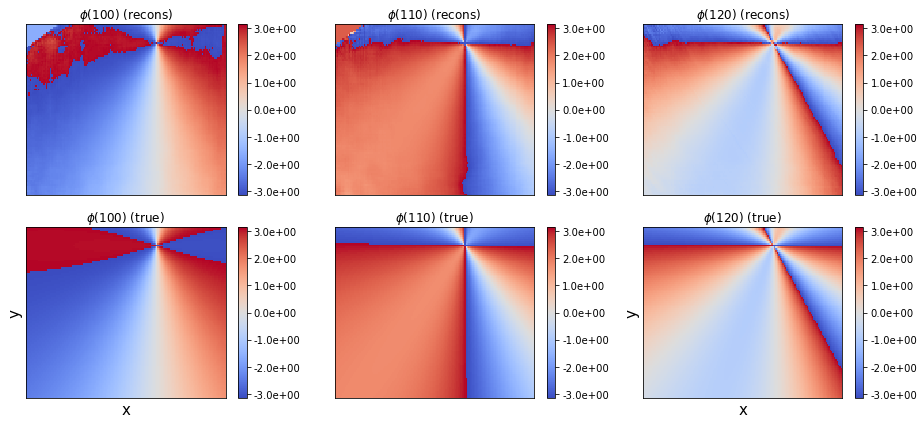

In [58]:
figsize_x = 13 if recons.reconstruct_phases_only else 18
subplots_x = 3 if recons.reconstruct_phases_only else 5

fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 
for i, (key, value) in enumerate(recons_items.items()):
    if i == 0 and not recons.reconstruct_phases_only:
        vmin=-2.1
        vmax = 2.1
    elif i == 1 and not recons.reconstruct_phases_only:
        vmin = -0.21
        vmax = 0.21
    else:
        vmin = -np.pi
        vmax = np.pi
    
    #value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp0 = axs[0, i].pcolormesh(value, cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[0, i].set_title(key + " (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%2.1e")
    
    true_value = true_items[key] 
    #true_value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp1 = axs[1, i].pcolormesh(true_items[key], cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[1, i].set_title(key + " (true)")
    plt.colorbar(cp1, ax=axs[1, i], format="%2.1e")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

axs[1,2].set_xlabel('x', fontsize=15)
axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()

if save_plots:
    
    plt.savefig(f'{data_path}_recons.png', bbox_inches='tight')
plt.show()

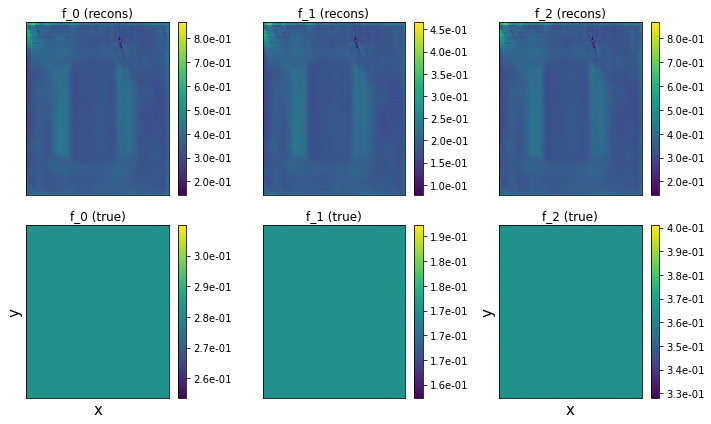

In [59]:
fig, axs = plt.subplots(2, 3, figsize=[10, 6]) 

for i in range(3):
    recons_amplitudes = amplitudes_2d_all[i]
    true_amplitudes = np.abs(sm.sample.rhos[i, recons.pady0: recons.pady0 + recons.npix_y, 
                                            recons.padx0: recons.padx0 + recons.npix_x, recons.npix_z//2])
    
    cp0 = axs[0, i].pcolormesh(recons_amplitudes)
    axs[0, i].set_title(f"f_{i} (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%.1e")
    
    cp1 = axs[1, i].pcolormesh(true_amplitudes)
    axs[1, i].set_title(f"f_{i} (true)")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    plt.colorbar(cp1, ax=axs[1, i], format="%.1e")
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

axs[1,2].set_xlabel('x', fontsize=15)
axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}_recons_amplitudes.png', bbox_inches='tight')
plt.show()

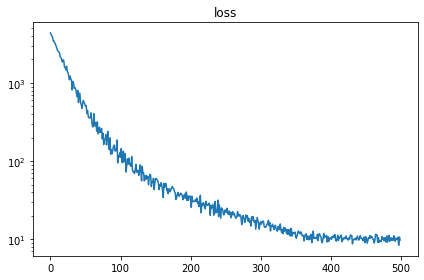

In [60]:
plt.plot(recons.loss_per_iter)
plt.title("loss")
plt.yscale('log')
plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}_loss.png', bbox_inches='tight')
plt.show()

In [63]:
if recons.reconstruct_phases_only:
    np.savez_compressed(data_path + 'rho_out.npz', rho_out)
else:
    np.savez_compressed(data_path + 'ux_out.npz', ux_out)
    np.savez_compressed(data_path + 'uy_out.npz', uy_out)

In [154]:
g1 = gradient1(ux1, periodicity=1.0, step_size=2.0)
g2 = gradient1(ux2, periodicity=1.0, step_size=2.0)
g3 = gradient1(ux3, periodicity=1.0, step_size=2.0)

In [155]:
g12 = gradient2(ux1, periodicity=1.0, step_size=2.0)
g22 = gradient2(ux2, periodicity=1.0, step_size=2.0)
g32 = gradient2(ux3, periodicity=1.0, step_size=2.0)

In [160]:
uxg_norm1 = np.linalg.norm(np.gradient(unwrap_phase(ux1 * np.pi * 2 / 1.0) * 1.0 / ( 2 * np.pi)), axis=0)
uxg_norm2 = np.linalg.norm(np.gradient(unwrap_phase(ux2 * np.pi * 2 / 1.0) * 1.0 / ( 2 * np.pi)), axis=0)
uxg_norm3 = np.linalg.norm(np.gradient(unwrap_phase(ux3 * np.pi * 2 / 1.0) * 1.0 / ( 2 * np.pi)), axis=0)

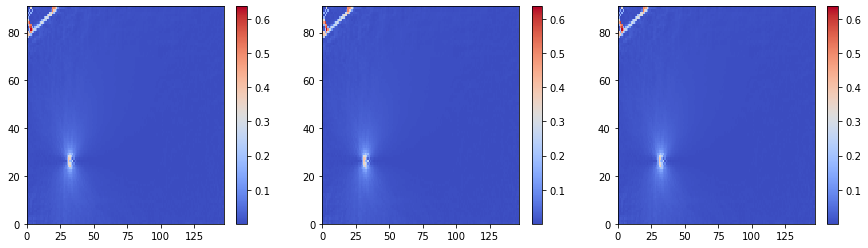

In [161]:
plt.figure(figsize=[15,4])
plt.subplot(1,3,1)
plt.pcolormesh(uxg_norm1, cmap='coolwarm')
plt.colorbar()
plt.subplot(1,3,2)
plt.pcolormesh(uxg_norm2, cmap='coolwarm')
plt.colorbar()

plt.subplot(1,3,3)
plt.pcolormesh(uxg_norm3, cmap='coolwarm')
plt.colorbar()

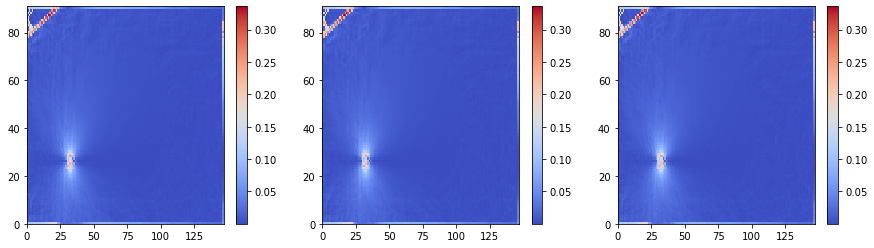

In [162]:
plt.figure(figsize=[15,4])
plt.subplot(1,3,1)
plt.pcolormesh(np.linalg.norm(g1, axis=0), cmap='coolwarm')
plt.colorbar()
plt.subplot(1,3,2)
plt.pcolormesh(np.linalg.norm(g2, axis=0), cmap='coolwarm')
plt.colorbar()

plt.subplot(1,3,3)
plt.pcolormesh(np.linalg.norm(g3, axis=0), cmap='coolwarm')
plt.colorbar()

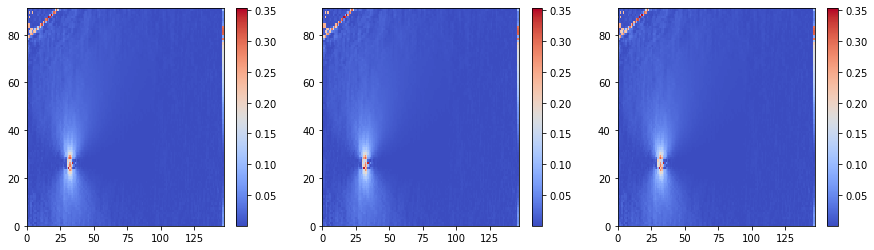

In [148]:
plt.figure(figsize=[15,4])
plt.subplot(1,3,1)
plt.pcolormesh(np.linalg.norm(g12, axis=0), cmap='coolwarm')
plt.colorbar()
plt.subplot(1,3,2)
plt.pcolormesh(np.linalg.norm(g22, axis=0), cmap='coolwarm')
plt.colorbar()

plt.subplot(1,3,3)
plt.pcolormesh(np.linalg.norm(g32, axis=0), cmap='coolwarm')
plt.colorbar()

In [125]:
min1 = np.argmin([uxg_norm1, uxg_norm2, uxg_norm3], axis=0)

In [77]:
choices = np.choose(min1, np.array([ux1, ux2, ux3]))

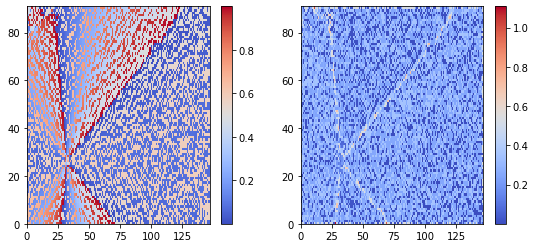

In [163]:
plt.figure(figsize=[9,4])
plt.subplot(1,2,1)
plt.pcolormesh(choices, cmap='coolwarm')
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(np.linalg.norm(np.gradient(choices), axis=0), cmap='coolwarm')
plt.colorbar()

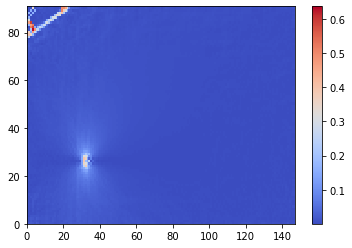

In [79]:
plt.pcolormesh(np.choose(min1, np.array([uxg_norm1, uxg_norm2, uxg_norm3])), cmap='coolwarm')
plt.colorbar()

### Thoughts
- it make sense to impose periodicity in the phases and not the displacements
- this is because the periodicity affects the peaks differently. for example:
    - for the 1, 0, 0 peak, you have a periodicity of a full lattice displacement in ux
    - for the 2, 0, 0 peak, you have a periodicity of a half lattice displacement in ux
- this means that if you shift the normalized displacements by 0.5, you still stay at the minimum for
  the 2, 0, 0 peak, but NOT at the minimum for hte 1, 0, 0 peak
- this creates local minima all over the place.

In [167]:
sm.params.HKL_list.shape[0]

3

In [168]:
tf.math.cos

<function tensorflow.python.ops.gen_math_ops.cos(x, name=None)>